# SDG&E Test System Data Preprocessing

This notebook is used to preprocess the data needed to create the San Diego test system model.

In [1]:
# Libraries
import pylab as plt
import importlib
import os
from os.path import join
import networkx as nx
import numpy as np
import geopandas as gpd

# Modules
import utils
import graph_tools
importlib.reload(utils)
importlib.reload(graph_tools)
from utils import *
from graph_tools import *

# Path the data directory
DATA_DIR = join(os.getcwd(), 'data')

In [12]:
# Read all CATS datasets (standardizing column names where needed)
buses = (read_geocsv('CATS_buses.csv')
         .rename(columns={'bus_i':'bus'})
        )

lines = (gpd
         .read_file(join(DATA_DIR, 'cats', 'CATS_lines.json'))
         .pipe(standardize)
         .rename(columns={'cats_id':'id', 'br_r':'r', 'br_x':'x', 'br_b':'b'})
        )

loads = read_loads('loads.csv')

gens = (read_mat('gencost.mat')
        .join(read_csv('CATS_generators.csv'))
        .pipe(add_id)
        )

wind_cf_gens = read_csv("CATS_wind_latlon_cf.csv").set_index('bus').iloc[:, 4:]
wind_cf_gens.columns = pd.to_datetime(wind_cf_gens.columns)

# Move the 2020 solar capcity factors back two years to be set in 2018 (with wind and loads)
solar_cf_gens = read_csv('CATS_busg_to_bus_latlon_cf.csv').set_index('bus').iloc[:, 10:]
solar_cf_gens.columns = wind_cf_gens.columns 
# Capacity factors for demand nodes
solar_cf_demand = read_csv('CATS_demand_to_bus_latlon_cf.csv').set_index('bus').iloc[:, 10:] 
solar_cf_demand.columns = wind_cf_gens.columns 

# Read IOU shapefile and select SDG&E shape
ious = gpd.read_file(join(PATH, 'iou.geojson'))
sdge = ious[ious['Acronym'] == 'SDG&E'][['geometry']]

# Load CPUC Fire Threat Map
cpuc_filename = "CPUC_FireThreatMapTiers2_3_v3r_08_19_2021.gdb"
cpuc_firezones = (gpd.read_file(
                      join(os.getcwd(), "data", cpuc_filename))
                  .explode()        # Explode Multi-polygons
                  .to_crs("WGS84")) # Convert to standard lat-long
# Get just the firezones in San Diego 
sd_firezones = gpd.sjoin(cpuc_firezones, sdge)
# Add Tier risk as numerical variable for plotting
sd_firezones['Tier']=sd_firezones['HFTD'].str.split(' ').str[-1].astype(int)
# Trim zones for plotting purposes
sd_firezones.geometry = (sd_firezones['geometry']
                         .intersection(sdge.geometry.values[0]))

In [14]:
# Create a sub-system of lines, buses, and gens 
# Save all outputs to CSVs in the test-system folder
sub_lines, sub_buses, sub_gens, sub_cf = subset_system(sdge, lines, buses, gens, loads, solar_cf_gens, solar_cf_demand, wind_cf_gens)

Created a system with 489 buses. Removed 2 isolated buses.


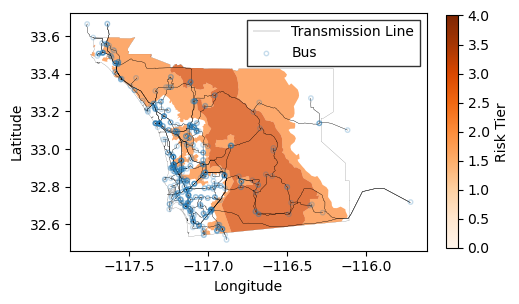

In [113]:
fig, ax = plt.subplots(figsize=(5,12))
gpd.GeoDataFrame(sub_lines, geometry="geometry").plot(ax=ax, color='k', lw=0.15, label="Transmission Line")
sub_buses.plot(ax=ax, zorder=2, alpha=0.25, facecolor='none', edgecolor='C0',  markersize=10, label="Bus")
sdge.plot(ax=ax, facecolor='none', edgecolor='k', lw = 0.1)
plt.legend(fancybox=False, edgecolor='k')


cmap = plt.cm.Oranges
vmin, vmax = 0, 4
norm = plt.Normalize(vmin=vmin, vmax=vmax)

sd_firezones.plot(ax=ax, column='Tier', cmap=cmap, norm=norm, alpha=0.75)

sm = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
sm._A = []  # required for ScalarMappable with no data array
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.05, label='Risk Tier')
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.savefig("test_system.png", dpi=600)

In [18]:
# Check that the subsystem is fully connected
graph = nx.from_pandas_edgelist(sub_lines, source='f_bus', target='t_bus')
print("System Connected:", 1==len(list(nx.connected_components(graph))))

System Connected: True


In [115]:
# Join San Diego sub-system with CPUC map to find high risk lines 
high_risk_line = gpd.sjoin(
    gpd.GeoDataFrame(sub_lines, crs="EPSG:4326"), 
    sd_firezones[['geometry', 'Tier']]).index 

# Lines in high risk area will be de-energized in final 24hrs
sub_lines["on"] = (~(sub_lines.index.isin(high_risk_line))).astype(int)
sub_lines.to_csv(join(os.getcwd(), '..', 'inputs', 'lines.csv'))